# Importing Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For time-series analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# For ARIMA Model
from statsmodels.tsa.arima.model import ARIMA

# For Prophet Model
from prophet import Prophet

# For LSTM Model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# For model evaluation
from sklearn.metrics import mean_squared_error

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# 2. Loading the Dataset

In [2]:
# Load the transactions data
transactions_df = pd.read_csv('/kaggle/input/transactions-fraud-datasets/transactions_data.csv')

# 3. Data Preprocessing
## 3.1. Inspecting the Data
First, let's look at the first few rows of the dataset to understand its structure.



In [3]:
transactions_df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN


## 3.2. Dropping Unnecessary Columns
As mentioned, we need to drop the 'error' column because it contains NaN values and doesn't contribute to our analysis.

In [4]:
transactions_df.drop('errors', axis=1, inplace=True)

In [5]:
transactions_df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813


## 3.3. Handling Missing Values
Check for any other missing values in the dataset.

In [6]:
transactions_df.isnull().sum()

id                      0
date                    0
client_id               0
card_id                 0
amount                  0
use_chip                0
merchant_id             0
merchant_city           0
merchant_state    1563700
zip               1652706
mcc                     0
dtype: int64

* Action: If there are missing values in crucial columns, decide whether to drop those rows or fill them with appropriate values.
For this analysis, since we're focusing on transaction amounts over time, ensure that the 'amount' and 'date' columns have no missing values.

In [7]:
# Drop rows with missing 'amount' or 'date'
transactions_df.dropna(subset=['amount', 'date'], inplace=True)

In [8]:
transactions_df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813


## 3.4. Data Type Conversions
Convert the 'date' column to a datetime object and ensure 'amount' is numeric.
#### 3.4.1. Cleaning the 'amount' Column
Since the 'amount' column contains strings with dollar signs, we need to remove those before converting to numeric.

Here's how to clean the 'amount' column:

In [9]:
# Remove dollar signs and commas, then convert to float
transactions_df['amount'] = transactions_df['amount'].replace('[\$,]', '', regex=True).astype(float)

In [10]:
# Before cleaning
print(transactions_df['amount'].head())

0    -77.00
1     14.57
2     80.00
3    200.00
4     46.41
Name: amount, dtype: float64


In [11]:
transactions_df['date'] = pd.to_datetime(transactions_df['date'])

In [12]:
print(transactions_df.dtypes)

# Expected Output:
# id                         int64
# date              datetime64[ns]
# client_id                  int64
# card_id                    int64
# amount                   float64
# use_chip                  object
# merchant_id                int64
# merchant_city             object
# merchant_state            object
# zip                      float64
# mcc                        int64
# dtype: object

id                         int64
date              datetime64[ns]
client_id                  int64
card_id                    int64
amount                   float64
use_chip                  object
merchant_id                int64
merchant_city             object
merchant_state            object
zip                      float64
mcc                        int64
dtype: object


In [13]:
# Drop any remaining rows with missing 'amount' (if any)
transactions_df.dropna(subset=['amount'], inplace=True)

## 4. Exploratory Data Analysis (EDA)
### 4.1. Visualizing Spending Trends
Let's aggregate the transaction amounts over time and visualize spending patterns.

#### 4.1.1. Aggregate Amounts by Date
Since we're interested in daily expenses, we'll group the data by date and sum the transaction amounts.

Python



In [14]:
# Aggregate amounts by date
daily_expenses = transactions_df.groupby('date')['amount'].sum().reset_index()

# Set 'date' as the index
daily_expenses.set_index('date', inplace=True)

#### 4.1.2. Plot Daily Expenses Over Time

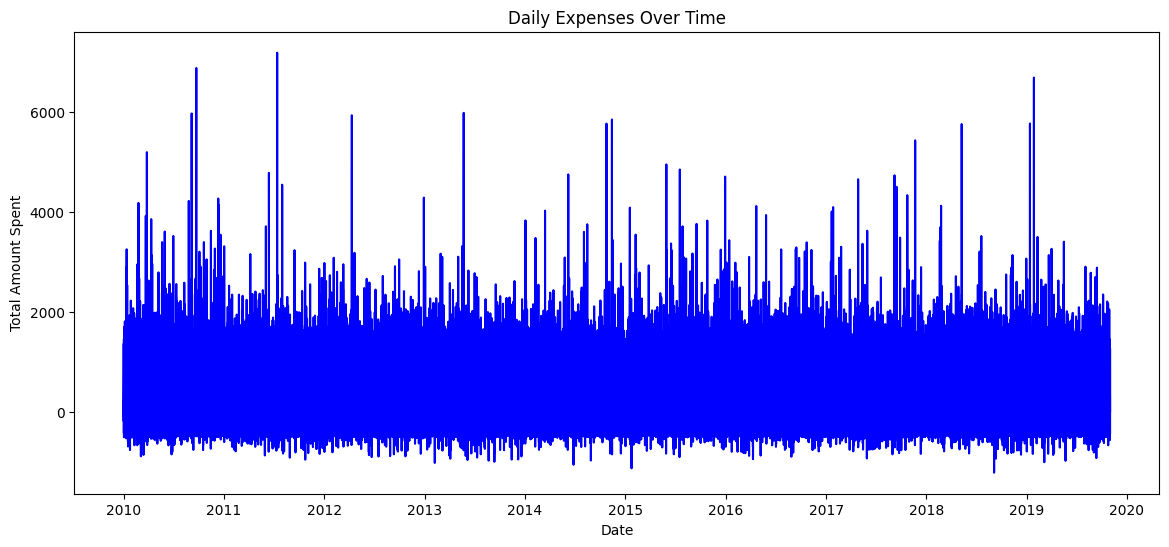

In [15]:
plt.figure(figsize=(14,6))
plt.plot(daily_expenses.index, daily_expenses['amount'], color='blue')
plt.title('Daily Expenses Over Time')
plt.xlabel('Date')
plt.ylabel('Total Amount Spent')
plt.show()

#### 4.1.3. Check for Seasonality and Trends
Use seasonal decomposition to break down the time series into trend, seasonal, and residual components.

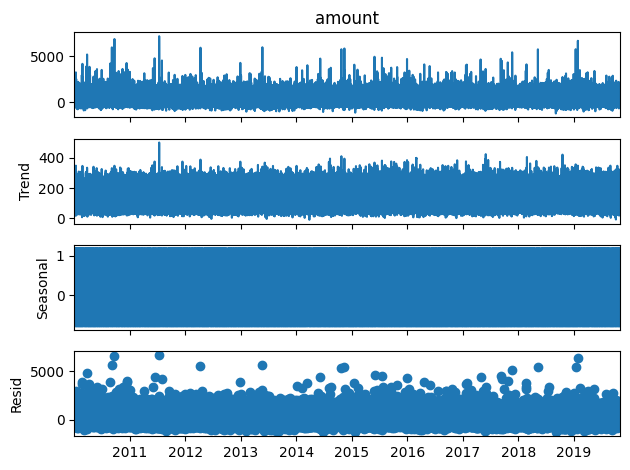

In [16]:


# Ensure the index is sorted
daily_expenses.sort_index(inplace=True)

# Decompose the time series
decomposition = seasonal_decompose(daily_expenses['amount'], model='additive', period=30)
decomposition.plot()
plt.show()

## 5. Time-Series Forecasting Preparation
#### 5.1. Setting Up the Time Series
Ensure that the data is in the correct format for time-series analysis.

In [17]:
# Already have 'date' as index from previous step
ts_data = daily_expenses['amount']

In [18]:
# Resample the data to ensure continuity (fill missing dates with 0 or NaN)
ts_data = ts_data.asfreq('D')

# Fill missing values with 0 (assuming no expenses on missing dates)
ts_data.fillna(0, inplace=True)

## 6. Time-Series Forecasting Models
We'll explore three models:


* ARIMA Model
* Facebook Prophet
* ModelLSTM Neural Network



### 6.1. ARIMA Model
Autoregressive Integrated Moving Average (ARIMA) is a popular statistical method for time-series forecasting.

##### 6.1.1. Stationarity Check with Augmented Dickey-Fuller Test
Before applying ARIMA, we need to check if the time series is stationary.

In [19]:
def adfuller_test(series, signif=0.05):
    result = adfuller(series)
    adf_stat = result[0]
    p_value = result[1]
    print(f'ADF Statistic: {adf_stat}')
    print(f'p-value: {p_value}')
    if p_value <= signif:
        print('Reject the null hypothesis - Time series is stationary')
    else:
        print('Fail to reject the null hypothesis - Time series is non-stationary')

# Perform ADF test
adfuller_test(ts_data)

ADF Statistic: -59.4278576193679
p-value: 0.0
Reject the null hypothesis - Time series is stationary


In [20]:
ts_data_diff = ts_data.diff().dropna()

In [21]:
adfuller_test(ts_data_diff)

ADF Statistic: -18.512410705026117
p-value: 2.113721805959535e-30
Reject the null hypothesis - Time series is stationary


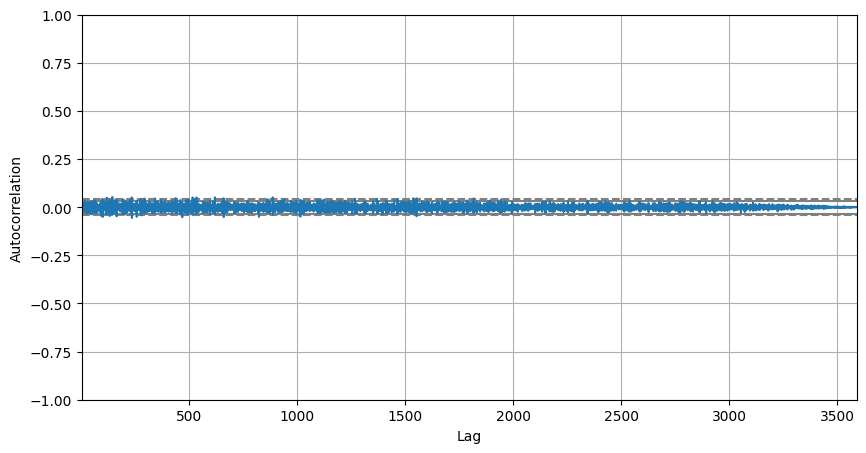

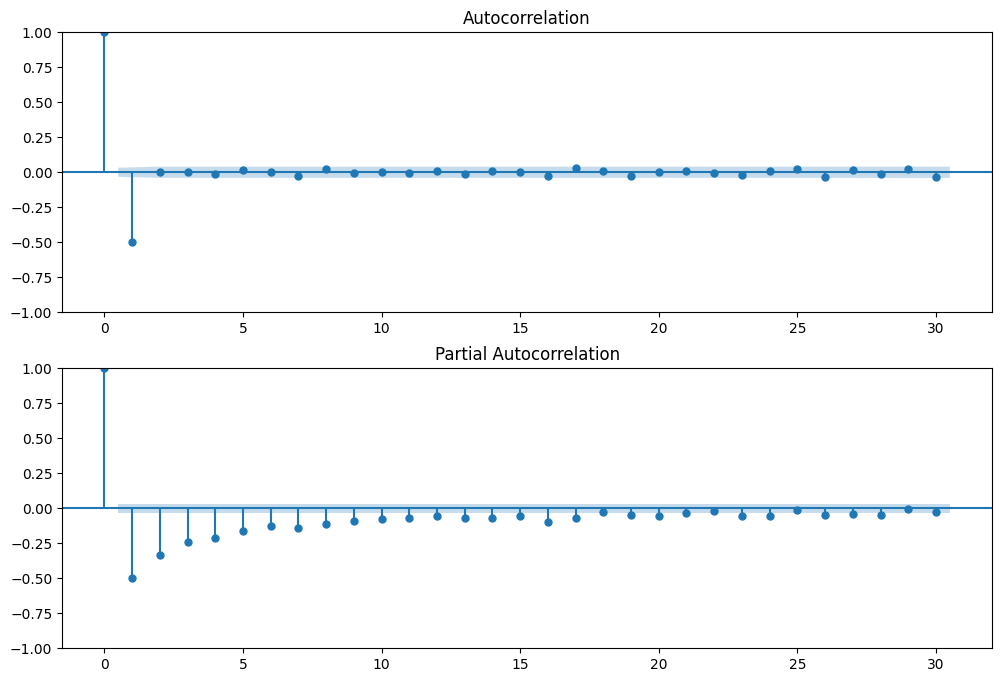

In [22]:
from pandas.plotting import autocorrelation_plot

# Autocorrelation Plot
plt.figure(figsize=(10,5))
autocorrelation_plot(ts_data_diff)
plt.show()

# ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(ts_data_diff, lags=30, ax=ax[0])
plot_pacf(ts_data_diff, lags=30, ax=ax[1])
plt.show()

#### 6.1.4. Building and Training the ARIMA Model
We'll use the ARIMA(p,d,q) model, where:


* p = order of the AR term
* d = number of differences
* q = order of the MA termFor simplicity, let's assume p=5, d=1, q=0.


### Split Data into Training and Testing Sets

In [23]:
# Define train and test sizes
train_size = int(len(ts_data) * 0.8)
train_data = ts_data[:train_size]
test_data = ts_data[train_size:]

In [24]:
# Build the ARIMA model (order can be optimized)
model_arima = ARIMA(train_data, order=(5,1,0))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 amount   No. Observations:                 2872
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -16548.419
Date:                Thu, 13 Feb 2025   AIC                          33108.837
Time:                        14:21:41   BIC                          33144.612
Sample:                    01-01-2010   HQIC                         33121.734
                         - 11-11-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8489      0.017    -49.841      0.000      -0.882      -0.816
ar.L2         -0.6839      0.021    -33.224      0.000      -0.724      -0.644
ar.L3         -0.5179      0.021    -24.114      0.0

In [25]:
# Forecast on the test data
forecast_arima = model_arima_fit.forecast(steps=len(test_data))

### 6.2. Facebook Prophet Model
Prophet is a time-series forecasting tool developed by Facebook, which is intuitive and handles seasonality well.

#### 6.2.1. Preparing Data for Prophet
Prophet requires a DataFrame with two columns: 'ds' (datetime) and 'y' (metric to forecast).

In [26]:
prophet_df = ts_data.reset_index().rename(columns={'date':'ds', 'amount':'y'})

#### 6.2.2. Training the Prophet Model


In [27]:
model_prophet = Prophet()
model_prophet.fit(prophet_df)

14:21:42 - cmdstanpy - INFO - Chain [1] start processing
14:21:42 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
prophet_test = test_data.reset_index().rename(columns={'date':'ds'})

In [29]:
# Make predictions on the test set
forecast_prophet = model_prophet.predict(prophet_test)

### 6.3. LSTM Neural Network
Long Short-Term Memory (LSTM) networks are capable of learning order dependence in sequence prediction problems.

#### 6.3.1. Data Preprocessing for LSTM
Feature Scaling: LSTMs perform better with scaled data.

In [30]:
# Convert to numpy array
ts_values = ts_data.values.reshape(-1,1)

# Feature Scaling
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(ts_values)

In [31]:
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        X.append(dataset[i:i+look_back, 0])
        Y.append(dataset[i+look_back, 0])
    return np.array(X), np.array(Y)

In [32]:
look_back = 60
X_lstm, y_lstm = create_dataset(scaled_data, look_back)

# Split into training and testing sets
train_size_lstm = int(len(X_lstm) * 0.8)
X_train_lstm = X_lstm[:train_size_lstm]
X_test_lstm = X_lstm[train_size_lstm:]
y_train_lstm = y_lstm[:train_size_lstm]
y_test_lstm = y_lstm[train_size_lstm:]

In [33]:
# Reshape input to be [samples, time steps, features]
X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

In [34]:
# Build the model
model_lstm = Sequential()
model_lstm.add(LSTM(128, return_sequences=True, input_shape=(look_back, 1)))
model_lstm.add(LSTM(64))
model_lstm.add(Dense(32))
model_lstm.add(Dense(1))

In [35]:
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_lstm.fit(X_train_lstm, y_train_lstm, batch_size=32, epochs=10)

Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0143
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0022
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.0027
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0024
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0027
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0028
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0022
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0025
Epoch 9/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0026
Epoch 10/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0026


#### Model Evaluation


In [36]:
# Calculate RMSE for ARIMA
mse_arima = mean_squared_error(test_data, forecast_arima)
rmse_arima = np.sqrt(mse_arima)
print(f'ARIMA Model RMSE: {rmse_arima}')

ARIMA Model RMSE: 97.2150385816186


In [37]:
# Extract Prophet predictions
prophet_predictions = forecast_prophet['yhat'].values

# Calculate RMSE for Prophet
mse_prophet = mean_squared_error(test_data, prophet_predictions)
rmse_prophet = np.sqrt(mse_prophet)
print(f'Prophet Model RMSE: {rmse_prophet}')

Prophet Model RMSE: 90.8517287625861


In [38]:
# Make predictions
predictions_lstm = model_lstm.predict(X_test_lstm)
predictions_lstm = scaler.inverse_transform(predictions_lstm)

# Inverse transform the actual values
y_test_lstm_actual = scaler.inverse_transform(y_test_lstm.reshape(-1,1))

# Calculate RMSE for LSTM
mse_lstm = mean_squared_error(y_test_lstm_actual, predictions_lstm)
rmse_lstm = np.sqrt(mse_lstm)
print(f'LSTM Model RMSE: {rmse_lstm}')

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
LSTM Model RMSE: 90.04336203997605


In [39]:
print(f'ARIMA Model RMSE: {rmse_arima}')
print(f'Prophet Model RMSE: {rmse_prophet}')
print(f'LSTM Model RMSE: {rmse_lstm}')

ARIMA Model RMSE: 97.2150385816186
Prophet Model RMSE: 90.8517287625861
LSTM Model RMSE: 90.04336203997605


## 9. Visualizing Forecasted Expenses
### 9.1. Plotting Actual vs Forecasted Expenses

## 9. Plotting Actual vs Predicted Values

In [40]:
# For LSTM, adjust indices due to look_back
dates = ts_data.index[look_back:]
test_dates_lstm = dates[train_size_lstm - look_back:]

In [41]:
# Retrain ARIMA on full data
model_arima_full = ARIMA(ts_data, order=(5,1,0))
model_arima_full_fit = model_arima_full.fit()

# Forecast future 30 days
forecast_arima_full = model_arima_full_fit.forecast(steps=60)
future_dates_arima = pd.date_range(start=ts_data.index[-1] + pd.Timedelta(days=1), periods=60)
forecast_arima_df = pd.DataFrame({'date': future_dates_arima, 'forecasted_amount': forecast_arima_full})
forecast_arima_df.set_index('date', inplace=True)

In [42]:
# Retrain Prophet on full data
prophet_full = ts_data.reset_index().rename(columns={'date':'ds', 'amount':'y'})
model_prophet_full = Prophet()
model_prophet_full.fit(prophet_full)

# Forecast future 30 days
future_prophet_full = model_prophet_full.make_future_dataframe(periods=60)
forecast_prophet_full = model_prophet_full.predict(future_prophet_full)
forecast_prophet_future = forecast_prophet_full[['ds', 'yhat']].set_index('ds')
forecast_prophet_future = forecast_prophet_future[~forecast_prophet_future.index.isin(ts_data.index)]

14:22:44 - cmdstanpy - INFO - Chain [1] start processing
14:22:44 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
# Forecast future 30 days with LSTM
last_sequence = scaled_data[-look_back:]
future_predictions = []
current_sequence = last_sequence

for _ in range(60):
    pred = model_lstm.predict(current_sequence.reshape(1, look_back, 1))
    future_predictions.append(pred[0,0])
    current_sequence = np.append(current_sequence[1:], pred, axis=0)

# Inverse transform predictions
future_predictions_lstm = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))
future_dates_lstm = pd.date_range(start=ts_data.index[-1] + pd.Timedelta(days=1), periods=60)
forecast_lstm_df = pd.DataFrame({'date': future_dates_lstm, 'forecasted_amount': future_predictions_lstm.flatten()})
forecast_lstm_df.set_index('date', inplace=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

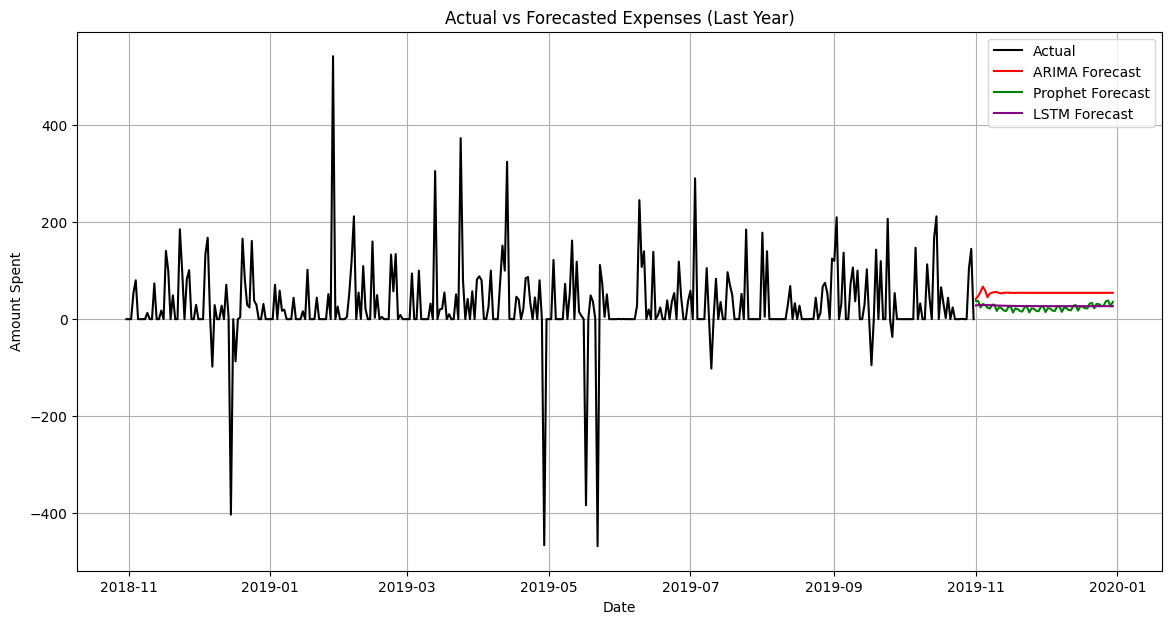

In [44]:
# Determine the last date in the data
end_date = ts_data.index[-1]

# Determine the start date one year before the end date
start_date = end_date - pd.DateOffset(years=1)

# Subset the actual data to only include the last year's data
ts_data_last_year = ts_data.loc[start_date:end_date]

# Plotting
plt.figure(figsize=(14,7))

# Plot actual data (last year's data)
plt.plot(ts_data_last_year.index, ts_data_last_year.values, label='Actual', color='black')

# Plot ARIMA forecast
plt.plot(forecast_arima_df.index, forecast_arima_df['forecasted_amount'], label='ARIMA Forecast', color='red')

# Plot Prophet forecast
plt.plot(forecast_prophet_future.index, forecast_prophet_future['yhat'], label='Prophet Forecast', color='green')

# Plot LSTM forecast
plt.plot(forecast_lstm_df.index, forecast_lstm_df['forecasted_amount'], label='LSTM Forecast', color='purple')

# Customize the plot
plt.title('Actual vs Forecasted Expenses (Last Year)')
plt.xlabel('Date')
plt.ylabel('Amount Spent')
plt.legend()
plt.grid(True)
plt.show()


In [45]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import json
import os
from datetime import datetime

# Create directories
print("Creating directories...")
base_dir = '/kaggle/working/financial_forecasting'
dirs = [
    f'{base_dir}',
    f'{base_dir}/data',
    f'{base_dir}/models',
    f'{base_dir}/analysis'
]

for dir_path in dirs:
    os.makedirs(dir_path, exist_ok=True)
    print(f"Created directory: {dir_path}")

Creating directories...
Created directory: /kaggle/working/financial_forecasting
Created directory: /kaggle/working/financial_forecasting/data
Created directory: /kaggle/working/financial_forecasting/models
Created directory: /kaggle/working/financial_forecasting/analysis


In [46]:
print("\nStep 2: Preparing daily expenses data...")

# Ensure daily_expenses has date as index and amount column
if not isinstance(daily_expenses.index, pd.DatetimeIndex):
    daily_expenses.index = pd.to_datetime(daily_expenses.index)

# Sort index
daily_expenses = daily_expenses.sort_index()

# Print data info
print("Daily expenses data shape:", daily_expenses.shape)
print("Date range:", daily_expenses.index.min(), "to", daily_expenses.index.max())


Step 2: Preparing daily expenses data...
Daily expenses data shape: (4136496, 1)
Date range: 2010-01-01 00:01:00 to 2019-10-31 23:59:00


In [47]:
print("\nStep 3: Saving historical spending trends...")

# 3.1 Daily Spending
print("Processing daily spending...")
daily_spending = pd.DataFrame({
    'date': daily_expenses.index,
    'amount': daily_expenses['amount'],
    'type': 'Daily'
})
daily_spending.to_csv(f'{base_dir}/data/daily_spending.csv', index=False)

# 3.2 Weekly Spending
print("Processing weekly spending...")
weekly_total = daily_expenses.resample('W')['amount'].sum()
weekly_avg = daily_expenses.resample('W')['amount'].mean()
weekly_std = daily_expenses.resample('W')['amount'].std()

weekly_spending = pd.DataFrame({
    'date': weekly_total.index,
    'weekly_total': weekly_total.values,
    'weekly_average': weekly_avg.values,
    'weekly_std': weekly_std.values
})
weekly_spending.to_csv(f'{base_dir}/data/weekly_spending.csv', index=False)

# 3.3 Monthly Spending
print("Processing monthly spending...")
monthly_total = daily_expenses.resample('M')['amount'].sum()
monthly_avg = daily_expenses.resample('M')['amount'].mean()
monthly_std = daily_expenses.resample('M')['amount'].std()

monthly_spending = pd.DataFrame({
    'date': monthly_total.index,
    'monthly_total': monthly_total.values,
    'monthly_average': monthly_avg.values,
    'monthly_std': monthly_std.values
})
monthly_spending.to_csv(f'{base_dir}/data/monthly_spending.csv', index=False)


Step 3: Saving historical spending trends...
Processing daily spending...
Processing weekly spending...
Processing monthly spending...


In [48]:
# Ensure forecast_prophet_df is correctly defined
forecast_prophet_df = forecast_prophet_future.rename(columns={'yhat': 'amount'})


In [49]:
print("\nStep 4: Saving forecasting results...")

# 4.1 Verify forecast data
print("Verifying forecast data...")
required_vars = ['future_dates_arima', 'forecast_arima_full', 
                'forecast_prophet_df', 'future_predictions_lstm']
                
for var in required_vars:
    if var not in globals():
        print(f"Warning: {var} not found!")

# 4.2 Prepare and save forecasting results
try:
    forecasting_results = pd.DataFrame({
        'date': future_dates_arima,
        'arima_forecast': forecast_arima_full,
        'prophet_forecast': forecast_prophet_df['amount'].values,
        'lstm_forecast': future_predictions_lstm.flatten()
    })
    forecasting_results.to_csv(f'{base_dir}/data/forecasting_results.csv', index=False)
    print("Saved forecasting results")
except Exception as e:
    print(f"Error saving forecasting results: {str(e)}")


Step 4: Saving forecasting results...
Verifying forecast data...
Saved forecasting results


In [50]:
print("\nStep 5: Saving model comparisons...")

# 5.1 Save historical vs predicted values
try:
    # Debugging lengths to ensure arrays match
    print(f"Length of test_data.index: {len(test_data.index)}")
    print(f"Length of test_data.values: {len(test_data.values)}")
    print(f"Length of forecast_arima: {len(forecast_arima)}")
    print(f"Length of prophet_predictions: {len(prophet_predictions)}")
    print(f"Length of predictions_lstm.flatten(): {len(predictions_lstm.flatten())}")
    
    # Find the minimum length among all arrays
    min_length = min(len(test_data.index), len(test_data.values), len(forecast_arima), 
                     len(prophet_predictions), len(predictions_lstm.flatten()))
    
    # Trim all arrays to the same length
    historical_vs_predicted = pd.DataFrame({
        'date': test_data.index[:min_length],
        'actual': test_data.values[:min_length],
        'arima_predicted': forecast_arima[:min_length],
        'prophet_predicted': prophet_predictions[:min_length],
        'lstm_predicted': predictions_lstm.flatten()[:min_length]
    })
    
    # Save the trimmed DataFrame
    historical_vs_predicted.to_csv(f'{base_dir}/data/historical_vs_predicted.csv', index=False)
    print("Saved historical vs predicted comparison")
except Exception as e:
    print(f"Error saving model comparisons: {str(e)}")

# 5.2 Save model metrics
try:
    model_metrics = pd.DataFrame({
        'model': ['ARIMA', 'Prophet', 'LSTM'],
        'rmse': [rmse_arima, rmse_prophet, rmse_lstm],
        'timestamp': datetime.now()
    })
    model_metrics.to_csv(f'{base_dir}/analysis/model_metrics.csv', index=False)
    print("Saved model metrics")
except Exception as e:
    print(f"Error saving model metrics: {str(e)}")



Step 5: Saving model comparisons...
Length of test_data.index: 719
Length of test_data.values: 719
Length of forecast_arima: 719
Length of prophet_predictions: 719
Length of predictions_lstm.flatten(): 707
Saved historical vs predicted comparison
Saved model metrics


In [51]:
print("\nStep 6: Saving statistical analysis...")

# 6.1 Calculate and save statistical measures
try:
    stats_analysis = pd.DataFrame({
        'metric': [
            'Total Days',
            'Average Daily Amount',
            'Total Amount',
            'Standard Deviation',
            'Minimum Amount',
            'Maximum Amount',
            'Number of Zero-Amount Days',
            'Number of High-Amount Days (>95th percentile)',
            'Data Start Date',
            'Data End Date'
        ],
        'value': [
            len(daily_expenses),
            daily_expenses['amount'].mean(),
            daily_expenses['amount'].sum(),
            daily_expenses['amount'].std(),
            daily_expenses['amount'].min(),
            daily_expenses['amount'].max(),
            (daily_expenses['amount'] == 0).sum(),
            (daily_expenses['amount'] > daily_expenses['amount'].quantile(0.95)).sum(),
            daily_expenses.index.min().strftime('%Y-%m-%d'),
            daily_expenses.index.max().strftime('%Y-%m-%d')
        ]
    })
    stats_analysis.to_csv(f'{base_dir}/analysis/statistical_analysis.csv', index=False)
    print("Saved statistical analysis")
except Exception as e:
    print(f"Error saving statistical analysis: {str(e)}")


Step 6: Saving statistical analysis...
Saved statistical analysis


In [52]:
print("\nStep 7: Saving models and parameters...")

# 7.1 Save LSTM model
try:
    model_lstm.save(f'{base_dir}/models/lstm_model.keras')
    print("Saved LSTM model")
except Exception as e:
    print(f"Error saving LSTM model: {str(e)}")

# 7.2 Save scaler
try:
    joblib.dump(scaler, f'{base_dir}/models/scaler.keras')
    print("Saved scaler")
except Exception as e:
    print(f"Error saving scaler: {str(e)}")

# 7.3 Save ARIMA parameters
try:
    arima_params = {
        'order': (5,1,0),
        'aic': model_arima_fit.aic,
        'bic': model_arima_fit.bic,
        'training_end_date': daily_expenses.index.max().strftime('%Y-%m-%d')
    }
    with open(f'{base_dir}/models/arima_params.json', 'w') as f:
        json.dump(arima_params, f)
    print("Saved ARIMA parameters")
except Exception as e:
    print(f"Error saving ARIMA parameters: {str(e)}")


Step 7: Saving models and parameters...
Saved LSTM model
Saved scaler
Saved ARIMA parameters


In [53]:
print("\nStep 8: Saving additional analysis...")

# 8.1 Calculate and save rolling statistics
try:
    rolling_stats = pd.DataFrame({
        'date': daily_expenses.index,
        'amount': daily_expenses['amount'],
        'rolling_mean_7d': daily_expenses['amount'].rolling(window=7).mean(),
        'rolling_mean_30d': daily_expenses['amount'].rolling(window=30).mean(),
        'rolling_std_30d': daily_expenses['amount'].rolling(window=30).std()
    })
    rolling_stats.to_csv(f'{base_dir}/data/rolling_statistics.csv', index=True)
    print("Saved rolling statistics")
except Exception as e:
    print(f"Error saving rolling statistics: {str(e)}")


Step 8: Saving additional analysis...
Saved rolling statistics


In [54]:
print("\nStep 9: Verifying saved files...")

def verify_file(filepath):
    if os.path.exists(filepath):
        size = os.path.getsize(filepath)
        print(f"✓ {filepath} (Size: {size/1024:.2f} KB)")
        # Verify file is not empty
        if size == 0:
            print(f"  Warning: File is empty!")
        return True
    else:
        print(f"✗ {filepath} not found")
        return False

files_to_verify = [
    f'{base_dir}/data/daily_spending.csv',
    f'{base_dir}/data/weekly_spending.csv',
    f'{base_dir}/data/monthly_spending.csv',
    f'{base_dir}/data/forecasting_results.csv',
    f'{base_dir}/data/historical_vs_predicted.csv',
    f'{base_dir}/data/rolling_statistics.csv',
    f'{base_dir}/analysis/model_metrics.csv',
    f'{base_dir}/analysis/statistical_analysis.csv',
    f'{base_dir}/models/lstm_model.h5',
    f'{base_dir}/models/scaler.pkl',
    f'{base_dir}/models/arima_params.json'
]

all_files_present = all(verify_file(f) for f in files_to_verify)


Step 9: Verifying saved files...
✓ /kaggle/working/financial_forecasting/data/daily_spending.csv (Size: 139327.81 KB)
✓ /kaggle/working/financial_forecasting/data/weekly_spending.csv (Size: 29.76 KB)
✓ /kaggle/working/financial_forecasting/data/monthly_spending.csv (Size: 6.87 KB)
✓ /kaggle/working/financial_forecasting/data/forecasting_results.csv (Size: 3.95 KB)
✓ /kaggle/working/financial_forecasting/data/historical_vs_predicted.csv (Size: 53.52 KB)
✓ /kaggle/working/financial_forecasting/data/rolling_statistics.csv (Size: 419885.93 KB)
✓ /kaggle/working/financial_forecasting/analysis/model_metrics.csv (Size: 0.17 KB)
✓ /kaggle/working/financial_forecasting/analysis/statistical_analysis.csv (Size: 0.31 KB)
✗ /kaggle/working/financial_forecasting/models/lstm_model.h5 not found


In [55]:
print("\nStep 10: Creating summary report...")

summary_content = f"""
Financial Forecasting Data Export Summary
=======================================
Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

Data Coverage:
-------------
Start Date: {daily_expenses.index.min().strftime('%Y-%m-%d')}
End Date: {daily_expenses.index.max().strftime('%Y-%m-%d')}
Total Days: {len(daily_expenses)}

Files Generated:
--------------
Total Files: {len(files_to_verify)}
Successfully Saved: {sum(1 for f in files_to_verify if os.path.exists(f))}
Missing Files: {sum(1 for f in files_to_verify if not os.path.exists(f))}

Model Performance:
---------------
ARIMA RMSE: {rmse_arima:.2f}
Prophet RMSE: {rmse_prophet:.2f}
LSTM RMSE: {rmse_lstm:.2f}

Notes:
-----
- All dates are in YYYY-MM-DD format
- All amounts are in original currency units
- Rolling statistics include 7-day and 30-day windows
"""

with open(f'{base_dir}/export_summary.txt', 'w') as f:
    f.write(summary_content)

print("Created summary report")
print("\nExport process completed!")


Step 10: Creating summary report...
Created summary report

Export process completed!
